In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import auc, roc_curve, roc_auc_score, recall_score, confusion_matrix
from pathlib import Path
plt.ion()   # interactive mode

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Get patient and its category
----------------------------------

In [4]:
image_dir = "/gdrive/My Drive/Habtamu Project/40X/val"

In [5]:
def load_data():
  dir_path = Path(image_dir)
  category = []
  patient = []
  for cat_dir in dir_path.iterdir():  
    cat_label = cat_dir.stem
    print("*",cat_label)
    for img_name in cat_dir.glob('*.png'):
      img_label = img_name.stem
      splitted_image_name = img_label.split('-')
      patient_label = splitted_image_name[2]
      category.append(cat_label)
      patient.append(patient_label)
  return category, patient

In [6]:
cat_test, patient_test = load_data()

* benign
* malignant


In [7]:
len(list(np.unique(np.array(patient_test))))

28

Load Data
---------

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir="/gdrive/My Drive/Habtamu Project/40X"
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=8,
                                             shuffle=True, num_workers=6)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=8,
                                             num_workers=6)

dataset_sizes = len(train_datasets) + len(test_datasets)
class_names = train_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
print(class_names)

['benign', 'malignant']


Visualize images
----------------------------------

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


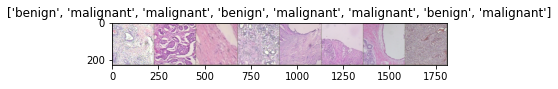

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])    

Training the model
------------------

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                data = train_dataloader
                dataset_sizes = len(train_datasets)
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                data = test_dataloader
                dataset_sizes = len(test_datasets)
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
----------------------------------

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Evaluation (AUC)

In [13]:
def evaluate_model_auc(model):
    was_training = model.training
    model.eval()
    y_truth = []
    y_predicted = []
    prob_predicted = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = torch.softmax(outputs, 1)
            for j in range(inputs.size()[0]):
              y_truth.append(labels.cpu()[j])
              y_predicted.append(preds.cpu()[j])
              prob_predicted.append(prob[:,1].cpu()[j])
        print(preds)   
        print(prob)    
        print("area under curve (AUC): ", roc_auc_score(y_truth, prob_predicted))

        fpr, tpr, thresholds = roc_curve(y_truth, prob_predicted)
        plt.figure(1)
        plt.plot([0,1],[0,1], 'y--')
        plt.plot(fpr, tpr, linestyle = '--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()
        model.train(mode=was_training)

# Evaluation (Recognition Rate)

In [14]:
def evaluate_model_rr(model):
    was_training = model.training
    model.eval()
    y_truth = []
    y_predicted = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = torch.softmax(outputs, 1)
            for j in range(inputs.size()[0]):
              y_truth.append(class_names[labels[j]])
              y_predicted.append(class_names[preds[j]])
        #print(y_predicted)
        #print(cat_test)
        #print(y_truth)
        unique_patient_test = list(np.unique(np.array(patient_test)))
        num_images_per_patient = []
        num_correctly_classified = []
        num = 0
        total_patient_score = 0
        num_patient = 0
        for patient in unique_patient_test:
          num_patient = num_patient + 1
          Np = 0
          Nrec = 0
          image_index_counter = -1
          for patient_label in patient_test:
            image_index_counter = image_index_counter + 1
            if patient == patient_label:
              if cat_test[image_index_counter] == y_predicted[image_index_counter]:
                Nrec = Nrec + 1
              Np = Np + 1
          patient_score = Nrec/Np
          #print(patient_score)
          num_images_per_patient.append(Np)
          num_correctly_classified.append(Nrec)
          total_patient_score = total_patient_score + patient_score
          num = num + Np    
        recognition_rate = total_patient_score/num_patient
        print("Summation of patient score: ", total_patient_score)
        print("Total Number of Patients: ", num_patient)
        print("Recognition Rate: ", recognition_rate)
        model.train(mode=was_training)

Finetuning the convnet
----------------------

In [15]:
model_ft = models.efficientnet_b0(pretrained=True) 
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Train and evaluate
----------------------------------

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4049 Acc: 0.8210
val Loss: 0.3457 Acc: 0.8402

Epoch 2/30
----------
train Loss: 0.2604 Acc: 0.8973
val Loss: 0.3480 Acc: 0.8307

Epoch 3/30
----------
train Loss: 0.2155 Acc: 0.9076
val Loss: 0.4131 Acc: 0.8180

Epoch 4/30
----------
train Loss: 0.2035 Acc: 0.9193
val Loss: 0.3856 Acc: 0.8196

Epoch 5/30
----------
train Loss: 0.1654 Acc: 0.9230
val Loss: 0.3759 Acc: 0.8497

Epoch 6/30
----------
train Loss: 0.1755 Acc: 0.9332
val Loss: 0.3750 Acc: 0.8481

Epoch 7/30
----------
train Loss: 0.1275 Acc: 0.9450
val Loss: 0.3213 Acc: 0.8465

Epoch 8/30
----------
train Loss: 0.1166 Acc: 0.9626
val Loss: 0.3045 Acc: 0.8734

Epoch 9/30
----------
train Loss: 0.1143 Acc: 0.9648
val Loss: 0.3161 Acc: 0.8481

Epoch 10/30
----------
train Loss: 0.1470 Acc: 0.9450
val Loss: 0.3140 Acc: 0.8639

Epoch 11/30
----------
train Loss: 0.1420 Acc: 0.9464
val Loss: 0.3162 Acc: 0.8718

Epoch 12/30
----------
train Loss: 0.1149 Acc: 0.9552
val Loss: 0.3558 Acc: 0.8402

Epoch 13/30
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


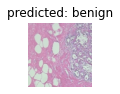

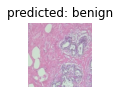

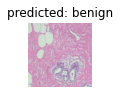

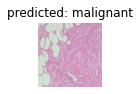

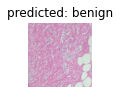

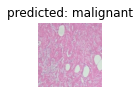

In [17]:
visualize_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
tensor([[0.1129, 0.8871],
        [0.9253, 0.0747],
        [0.4828, 0.5172],
        [0.2337, 0.7663],
        [0.8282, 0.1718],
        [0.8258, 0.1742],
        [0.9212, 0.0788],
        [0.6580, 0.3420]], device='cuda:0')
area under curve (AUC):  0.9428858901515151


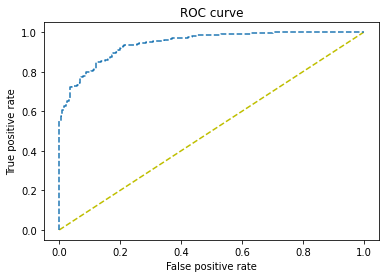

In [18]:
evaluate_model_auc(model_ft)

In [19]:
evaluate_model_rr(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Summation of patient score:  24.72935693245369
Total Number of Patients:  28
Recognition Rate:  0.8831913190162032
